<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Continuity


> Samples are needed for sequence models and transformer models for input

😈 **Task 1:** Why might LSTM be more effective for time series than a feedforward model like MLP?

😈 **Question 1:** What types of patterns are LSTM models particularly good at capturing?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
# variable_column = ["no2", "temp", "o3", "no", "press"]
variable_column = ["temp", "o3"]
TIMESERIES_DATA_DIR = "../time_series_forecasting/timeseries_data/"

In [2]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [4]:
from re import X
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# Please download the files and place them in content subfolder
# else modify below path according to your chosen local download path:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("../content/X_train.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open("../content/X_test.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("../content/y_train.pkl", "rb") as f:
    y_train_full = pickle.load(f)

with open("../content/y_test.pkl", "rb") as f:
    y_test_full = pickle.load(f)

print(f"X_train_full shape: {X_train_full.shape}, y_train_full shape: {y_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}, y_test_full shape: {y_test_full.shape}")

## Raw data csv is also made available for the select stations in URL:
# url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
# dataframe = pd.read_csv(url,parse_dates=["datetime"])
# Else if using local files:
dataframe = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}


# the station code is the first variable column, hence select only the last two
X_train = X_train_full[:,:,1:].copy()
X_test = X_test_full[:,:,1:].copy()

# for the label, we only want the ozone data, which is the second column
y_train = y_train_full[:,:,2].copy()
y_test = y_test_full[:,:,2].copy()

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# verify the shapes of the data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train_full shape: (69370, 336, 3), y_train_full shape: (69370, 96, 3)
X_test_full shape: (29730, 336, 3), y_test_full shape: (29730, 96, 3)
X_train shape: (69370, 336, 2), y_train shape: (69370, 96)
X_test shape: (29730, 336, 2), y_test shape: (29730, 96)


### Forecasting with Recurrent NN : LSTM

> LSTM multi step ahead and one step ahead predictions

😈 **Task 2:** Compare LSTM results with previous MLP results. What differences do you observe in performance and loss curves?

😈 **Task 3:** Visualize hidden states or prediction errors over time.

In [6]:
# Tunable LSTM parameters
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'
num_variables = len(variable_column)
# Reshape as a sanity check
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], len(variable_column)))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(variable_column)))

In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/1svSuEHTDMrkL_CrHqYHgtp2ZuWOuFTXS?usp=drive_link
# and the path needs to be updated to checkpoint_dir below to local downloaded path:
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, f"lstm_multivariate.h5")
## Ignore user warning on keras as the choice for this exercise is to use h5.

if os.path.exists(checkpoint_path):
    print(f"Loading existing model")
    lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
else:
    print(f"Training new model")

    lstm_model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(context_window, len(variable_column))), # change to allow mulitple input variables
        LSTM(lstm_units, return_sequences=False),
        Dense(prediction_horizon)
    ])

    lstm_model.compile(optimizer="adam", loss="mse")

    checkpoint_callback = ModelCheckpoint(
        checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
    )

    training = lstm_model.fit(
        X_train,
        y_train,
        epochs=lstm_epochs, batch_size=lstm_batch_size,
        validation_split=0.2, verbose=1,
        callbacks=[checkpoint_callback]
    )

    training_history = training.history

Training new model
Epoch 1/5


/opt/homebrew/anaconda3/envs/mless/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[:, :, var_idx]
    y_pred_single = lstm_predictions[:, :, var_idx]

    print(f"Variable {variable_column[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable temp:
RMSE: 8.2561


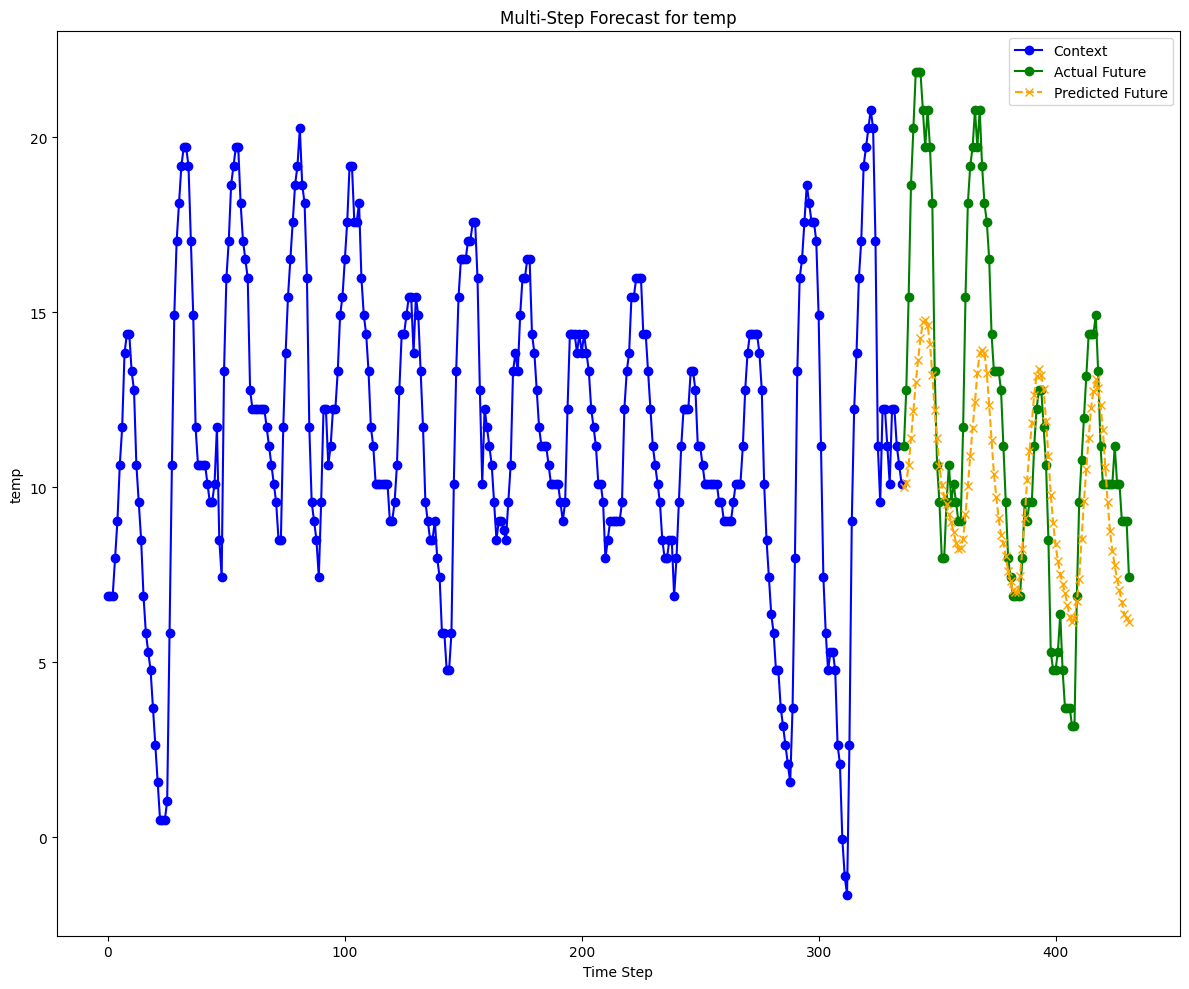

In [9]:
import csv
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_column):
    plt.subplot(len(variable_column), 1, var_idx + 1)

    # # Extract data for the last sample
    # context = X_test[-1, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    # actual_future = y_test_actual[-1, :, var_idx] #actual and pred denormalized in prev cell
    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    context=X_test_full[X_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1
    # First sample of DENW094 station to compare with PatchTST
    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    actual_future=y_test_full[y_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1

    predicted_future = lstm_predictions[-1, :, var_idx] #actual and pred denormalized in prev cell

    timesteps = np.arange(context_window, context_window + prediction_horizon)
    with open("denw094_temp_predictions_lstm.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["timestep", "temperature"])
        for t, pred in zip(timesteps, predicted_future):
            writer.writerow([t, pred])

    # Plot context
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    # Plot actual future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        actual_future,
        label="Actual Future",
        color="green",
        marker="o"
    )

    # Plot predicted future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        predicted_future,
        label="Predicted Future",
        color="orange",
        linestyle="--",
        marker="x"
    )

    plt.title(f"Multi-Step Forecast for {col}")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()


#### One Step ahead prediction

😈 **Task 5:** Train both one-step and multi-step models on the same dataset and compare RMSE.

😈 **Question 3:** In what real-world scenario would one-step prediction be more useful than multi-step?


In [ ]:
!mkdir -p checkpoint

!gdown --folder https://drive.google.com/drive/folders/11xQT7xvmA5Pj9VKck3C4wTOEUvX2gnIJ -O checkpoint

Retrieving folder contents
Processing file 1BXC__wuWz7n2ww3IEDaAarvcL5oDaoNw lstm_one_step_var0.h5
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1BXC__wuWz7n2ww3IEDaAarvcL5oDaoNw
To: /content/checkpoint/lstm_one_step_var0.h5
100% 407k/407k [00:00<00:00, 114MB/s]
Download completed


In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/11xQT7xvmA5Pj9VKck3C4wTOEUvX2gnIJ?usp=drive_link
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_column):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_column)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, 0, var_idx]

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_one_step_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(1)
        ])

        lstm_model.compile(optimizer=lstm_optim, loss=lstm_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single.reshape(-1, 1),
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model
lstm_predictions = np.zeros((y_test.shape[0], len(variable_column)))
y_test_actual = np.zeros((y_test.shape[0], len(variable_column)))


# Predict
for var_idx, col in enumerate(variable_column):
    print(f"Predicting for {col}...")

    # X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    X_test_sample=X_test_full[X_first_idx, :, var_idx+1].reshape(1,context_window,1).astype(np.float32) # First column is station code hence adding 1


    lstm_pred_single = lstm_model.predict(X_test_sample).flatten()
    lstm_predictions[:, var_idx] = lstm_pred_single

    # Inverse transform predictions and actual values
    lstm_predictions[:, var_idx] = (
        lstm_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[:, 0, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )



Training LSTM for variable 1/1: temp
Loading existing model for variable temp
Predicting for temp...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


In [ ]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[ :, var_idx]
    y_pred_single = lstm_predictions[ :, var_idx]

    print(f"Variable {variable_column[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable temp:
RMSE: 7.8887


In [ ]:
lstm_rolling_predictions = np.zeros((prediction_horizon, len(variable_column)))
y_test_actual = np.zeros((prediction_horizon, len(variable_column)))

# Select the last sample from the test set
X_test_single = X_test_lstm[-1]

for var_idx, col in enumerate(variable_column):
    # X_test_var = X_test_single[:, var_idx].reshape(1, context_window, 1)

    for step in range(prediction_horizon):
        lstm_pred_single = lstm_models[col].predict(X_test_sample)

        lstm_rolling_predictions[step, var_idx] = lstm_pred_single[0, 0]

        # Shift the window and append the new prediction
        X_test_sample = np.roll(X_test_sample, shift=-1, axis=1)
        X_test_sample[0, -1, 0] = lstm_pred_single

    # Inverse scale the predictions and actual values for the current variable
    lstm_rolling_predictions[:, var_idx] = (
        lstm_rolling_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[-1, :prediction_horizon, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-24-6383ac3a5a6e>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test_sample[0, -1, 0] = lstm_pred_single


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

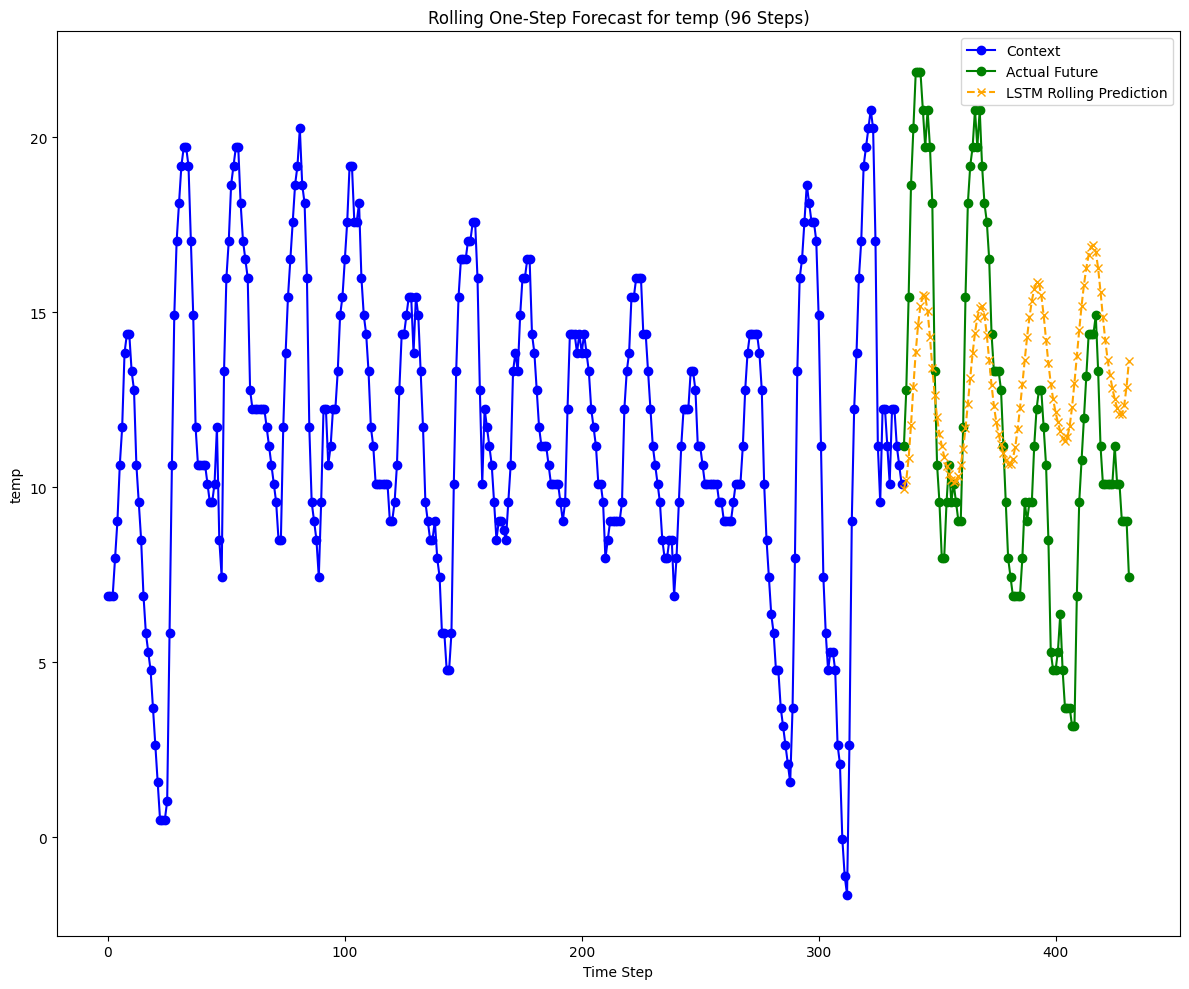

In [ ]:
# Plot Rolling One-Step-Ahead Forecast for All Variables (for the last sample)
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_column):
    plt.subplot(len(variable_column), 1, var_idx + 1)

    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    context=X_test_full[X_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1
    # First sample of DENW094 station to compare with PatchTST
    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    actual_future=y_test_full[y_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1

    predicted_future = lstm_rolling_predictions[:, var_idx] #actual and pred denormalized in prev cell

    

    # Plot context window
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), actual_future,
             label="Actual Future", color="green", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future,
             label="LSTM Rolling Prediction", color="orange", linestyle="--", marker="x")

    plt.title(f"Rolling One-Step Forecast for {col} ({prediction_horizon} Steps)")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()